# TP2 - MCMC

## Estimation avancée - G3 SDIA

Dans ce TP, on s'intéresse aux méthodes d'échantillonnage dites "MCMC" (Monte Carlo par Chaînes de Markov). Le premier exercice consiste à implémenter un Metropolis-Hastings et de regarder l'influence de quelques paramètres (disponible dans le premier notebook). Le deuxième exercice met en oeuvre une méthode de régression bayésienne linéaire.

### Instructions

1. Renommer votre notebook sous la forme `tp2b_Nom1_Nom2.ipynb`, et inclure le nom du binôme dans le notebook. 

2. Votre code, ainsi que toute sortie du code, doivent être commentés !

3. Déposer votre notebook sur Moodle dans la section prévue à cet effet avant la date limite : 10 Décembre 2023, 23h59.

In [10]:
import numpy as np
from matplotlib import pyplot as plt
import scipy.stats as ss
from sklearn import datasets

### Partie 2 - Régression linéaire bayésienne parcimonieuse

On suppose le modèle de régression linéaire suivant :
$$ y_i \sim \mathcal{N}(\mathbf{x}_i^{\top} \boldsymbol{\beta}, \sigma^2)$$

On a :
* $y \in \mathbb{R}$, la variable que l'on cherche à prédire ;
* $\mathbf{x}_i \in \mathbb{R}^p$, les features ;
* $\boldsymbol{\beta} \in \mathbb{R}^p$, le vecteur de régression ;
* $\sigma^2$ la variance du bruit.

Nous adoptons une approche bayésienne. Les paramètres du modèle, $\boldsymbol{\beta}$ et $\sigma^2$, doivent donc être munis d'une loi a priori.

Dans cet exercice, nous allons suivre le modèle du *Bayesian LASSO* ([Park et al. (2008)](https://people.eecs.berkeley.edu/~jordan/courses/260-spring09/other-readings/park-casella.pdf)).

Le LASSO est une méthode de régression pénalisée classique (c'est la pénalisation en norme $\ell_1$ - vous connaissez la pénalisation en norme $\ell_2$ appelée *ridge regression*). Nous regardons ici sa version bayésienne. Les lois a priori sont les suivantes :
\begin{align}
\sigma^2 & \sim \text{IG}(a_0, b_0) \\
\beta_p | \sigma^2 & \sim \text{Laplace} \left( 0, \frac{\sqrt{\sigma^2}}{\lambda} \right)
\end{align}

$\lambda$ est le paramètre de régularisation. Il se trouve qu'en prenant une loi a priori de [Laplace](https://en.wikipedia.org/wiki/Laplace_distribution) pour les coefficients de régression, le problème du LASSO est le même que celui l'estimation MAP.

À partir des données $\mathcal{D} = \{ (\mathbf{x}_1, y_1), ... (\mathbf{x}_n, y_n) \}$, l'objectif est donc de caractériser la loi a posteriori $p(\boldsymbol{\beta}, \sigma^2 | \mathcal{D})$. Elle n'est pas tractable analytiquement. Nous allons donc échantillonner de cette loi à l'aide d'un algorithme MCMC, plus précisémment, un [échantillonneur de Gibbs](https://fr.wikipedia.org/wiki/%C3%89chantillonnage_de_Gibbs).

Il n'est pas possible de dériver un échantillonneur de Gibbs immédiatement. Il se trouve que le modèle peut être ré-écrit de la manière suivante :
\begin{align}
\sigma^2 & \sim \text{IG}(a_0, b_0) \\
\tau_i^2 & \sim \text{Exp} \left( \frac{\lambda^2}{2} \right) \\
\beta_j | \tau_j^2, \sigma^2 & \sim \mathcal{N}(0, \sigma^2 \tau_j^2) \\
y_i | \boldsymbol{\beta}, \sigma^2 & \sim \mathcal{N}(\mathbf{x}_i^{\top} \boldsymbol{\beta}, \sigma^2)
\end{align}

On peut alors trouver les lois conditionnelles :
\begin{align}
\boldsymbol{\beta} | \boldsymbol{\tau}, \sigma^2, \mathcal{D} \sim \mathcal{N}(\mathbf{A} \mathbf{X}^{\top} \mathbf{y}, \sigma^2 \mathbf{A}),
\end{align}
avec $\mathbf{A} = (\mathbf{X}^{\top} \mathbf{X} + \mathbf{D}_{\tau})^{-1}$, où $\mathbf{D}_{\tau} = \text{diag}(\tau_1^{-2}, ..., \tau_p^{-2})$.
\begin{align}
\tau_j^{-2} | \boldsymbol{\beta}, \sigma^2, \mathcal{D} \sim \text{InvGaussian}\left( \sqrt{\frac{\lambda^2 \sigma^2}{\beta_j^2}}, \lambda^2 \right),
\end{align}
(Loi "Inverse-Gaussian" -> [ici](https://en.wikipedia.org/wiki/Inverse_Gaussian_distribution))
\begin{align}
\sigma^2 | \boldsymbol{\beta}, \boldsymbol{\tau}, \mathcal{D} \sim \text{IG}\left( a_0 + \frac{n+p}{2}, b_0 + \frac{1}{2} || \mathbf{y - X} \boldsymbol{\beta} ||^2_2 + \frac{1}{2} \sum_{j=1}^p \frac{\beta_j^2}{\tau_j^2} \right)
\end{align}

In [11]:
# Pre-processing the data

# Load the dataset
diabetes = datasets.load_diabetes()

# Print dataset description
print(diabetes.DESCR)

# Features
X = diabetes.data
X = X/np.std(X, axis = 0) # Standardize
N,P = X.shape

# Target
y = diabetes.target
y = (y-np.mean(y))/np.std(y) # Standardize

.. _diabetes_dataset:

Diabetes dataset
----------------

Ten baseline variables, age, sex, body mass index, average blood
pressure, and six blood serum measurements were obtained for each of n =
442 diabetes patients, as well as the response of interest, a
quantitative measure of disease progression one year after baseline.

**Data Set Characteristics:**

  :Number of Instances: 442

  :Number of Attributes: First 10 columns are numeric predictive values

  :Target: Column 11 is a quantitative measure of disease progression one year after baseline

  :Attribute Information:
      - age     age in years
      - sex
      - bmi     body mass index
      - bp      average blood pressure
      - s1      tc, total serum cholesterol
      - s2      ldl, low-density lipoproteins
      - s3      hdl, high-density lipoproteins
      - s4      tch, total cholesterol / HDL
      - s5      ltg, possibly log of serum triglycerides level
      - s6      glu, blood sugar level

Note: Each of these 1

**Q1.** Écrire une fonction implémentant l'échantillonnage de Gibbs dans ce modèle, qui prend en arguments :
* Les données sous forme matricielle $\mathbf{X}$ et $\mathbf{y}$
* Le nombre d'échantillons $N_g$
* La taille du *burn-in* $N_b$
* Les hyper-paramètres du modèle : $a_0, b_0, \lambda$

Elle retourne $N_g$ échantillons du posterior $p(\boldsymbol{\beta}, \sigma^2 | \mathcal{D})$.

**Attention !** Bien lire la doc. de `scipy.stats.invgauss` pour savoir quels paramètres utiliser.

In [12]:
def bayesian_lasso_gibbs(X, y, Ng, Nb, a0, b0, l):
    N, P = X.shape
    samples = np.zeros((Ng, P + 1))  # +1 pour inclure sigma^2 dans les échantillons

    # Initialisation
    beta = np.random.normal(0, 1, P)
    sigma2=(ss.invgamma.rvs(a0, scale=b0, size=1))**2
    tau2 = np.random.exponential(l**2/2, P)

    # Boucle d'échantillonnage de Gibbs
    for i in range(Ng + Nb):
        A = np.linalg.inv(X.T @ X + np.diag(1 / tau2))
        mean = A @ X.T @ y
        cov = sigma2 * A
        beta = np.random.multivariate_normal(mean, cov)
        tau2 = 1 / np.random.wald(np.sqrt(l**2 * sigma2 / beta**2), l**2)
        error = y - X @ beta
        a = a0 + (N + P) / 2
        b = b0 + 0.5 * (np.sum(error**2) + np.sum(beta**2 / tau2))
        sigma2 = 1 / np.random.gamma(a, 1 / b)

        if i >= Nb:  # On enregistre les échantillons après le burn-in
            samples[i - Nb, :-1] = beta
            samples[i - Nb, -1] = sigma2

    return samples

Ng = 1000  # Nombre d'échantillons
Nb = 500   # Taille du burn-in
a0, b0, l = 1, 1, 1  # Hyper-paramètres
samples = bayesian_lasso_gibbs(X, y, Ng, Nb, a0, b0, l)
samples

array([[-0.0173141 , -0.167609  ,  0.35135543, ...,  0.50797026,
         0.05233002,  0.50411895],
       [-0.08345027, -0.08605564,  0.38882211, ...,  0.38487831,
         0.06474122,  0.53998099],
       [-0.0479274 , -0.14964121,  0.32582425, ...,  0.24800505,
         0.08905457,  0.49969334],
       ...,
       [-0.01174167, -0.13561457,  0.36751527, ...,  0.37448064,
         0.09996143,  0.50468147],
       [ 0.00741904, -0.13795795,  0.28206437, ...,  0.41357139,
         0.0552878 ,  0.5105796 ],
       [ 0.05654139, -0.15613854,  0.37268818, ...,  0.47228705,
         0.02954607,  0.49264654]])

**Q2.** Faire tourner la chaîne MCMC avec les paramètres suivants : $N_g = N_b = 1000$, $a_0 = b_0 = 1$, $\lambda = 10$.

* Afficher le *traceplot* pour un paramètre de votre choix. Commenter.
* Pour chacun des paramètres $\boldsymbol{\beta}$ et $\sigma^2$, afficher un histogramme ou un KDE des $N_g$ échantillons obtenus. Afficher sur le même plot la valeur de l'estimation MMSE et MAP. Enfin, donner l'intervalle de crédibilité à 95%. (Cf. dernier chapitre du cours Intro à l'Estimation)


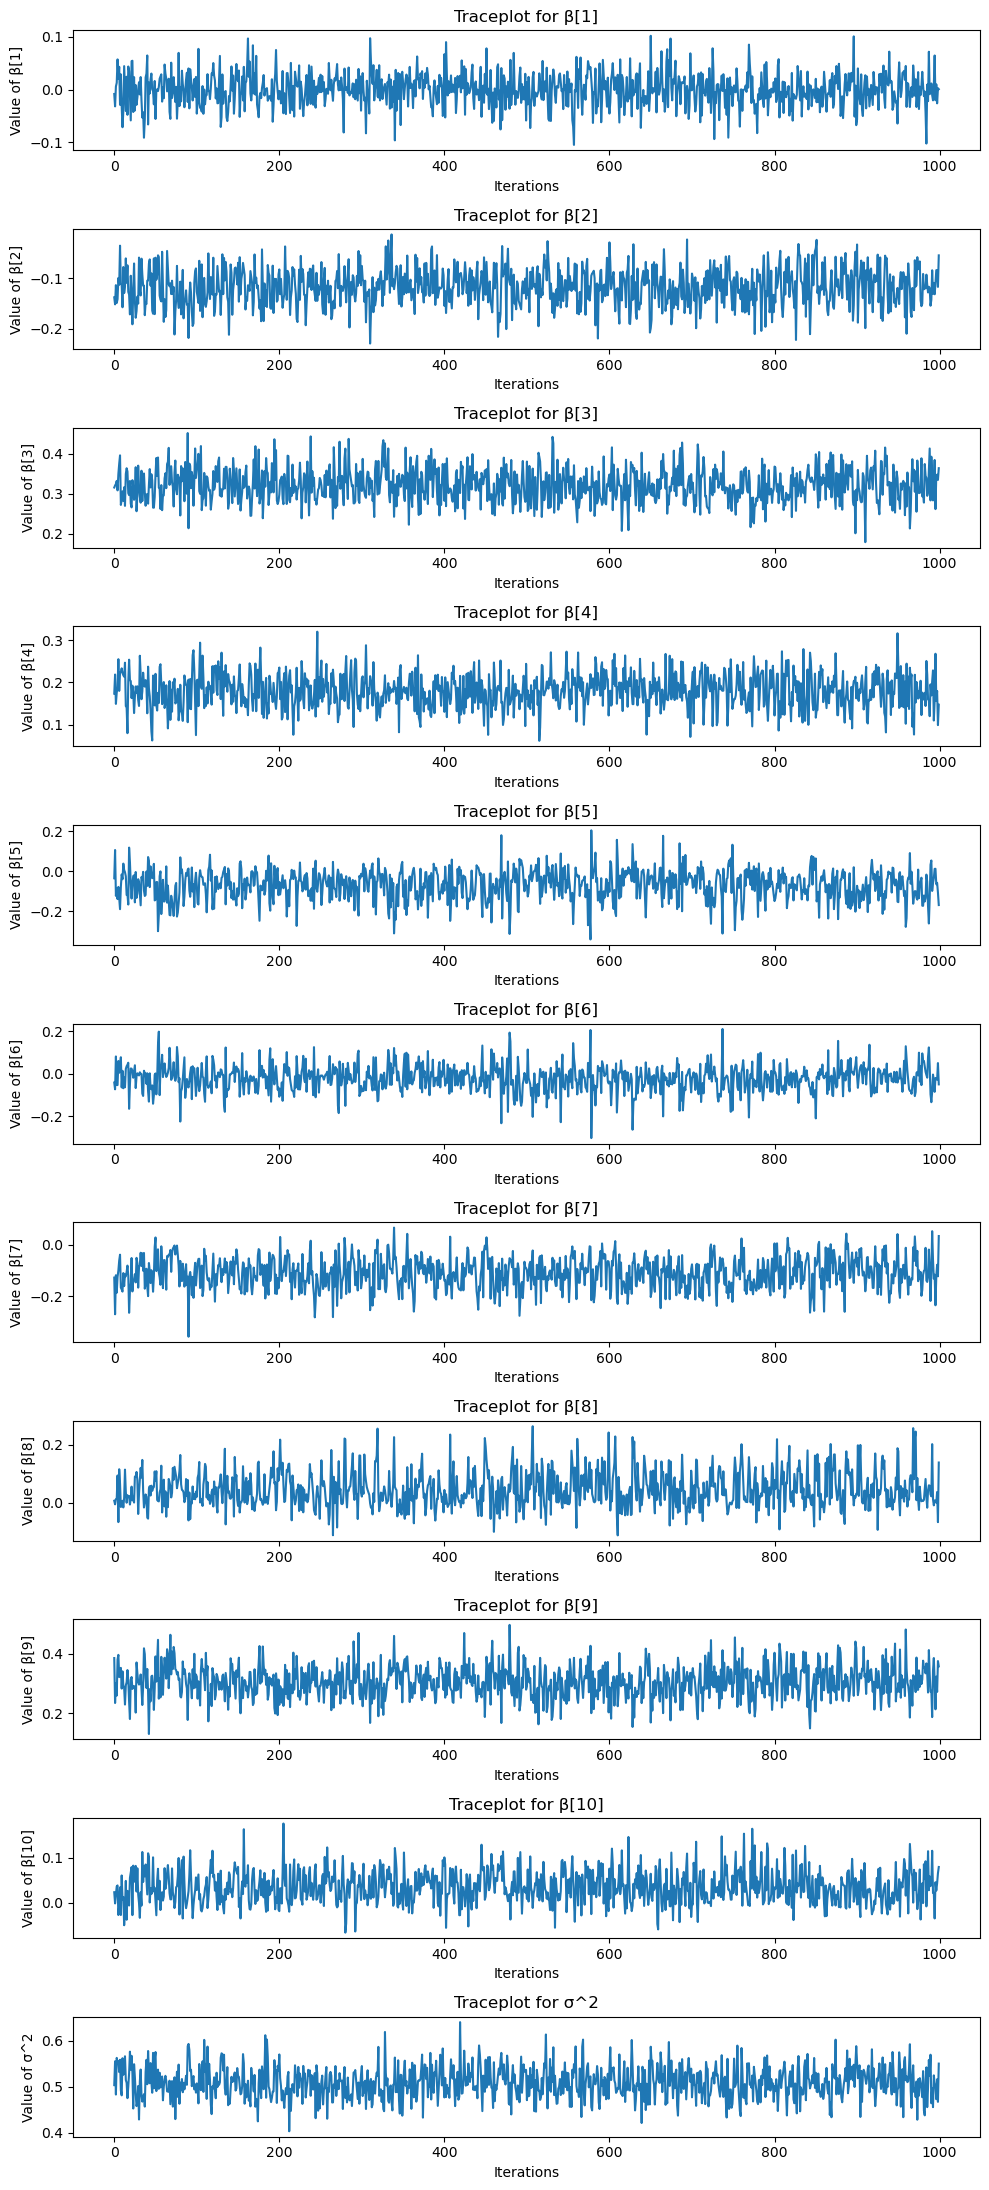

In [13]:
import plotly.graph_objects as go

Ng = 1000
Nb = 1000
a0 = 1
b0 = 1
l = 10

samples = bayesian_lasso_gibbs(X, y, Ng, Nb, a0, b0, l)
num_params = samples.shape[1]  # Nombre total de paramètres (incluant sigma^2)
param_names = [f"β[{i}]" for i in range(1, P + 1)] + ["σ^2"]  # Noms des paramètres

fig, axes = plt.subplots(num_params, 1, figsize=(10, 2 * num_params))

for i in range(num_params):
    ax = axes[i]
    ax.plot(samples[:, i])
    ax.set_title(f"Traceplot for {param_names[i]}")
    ax.set_xlabel("Iterations")
    ax.set_ylabel(f"Value of {param_names[i]}")

plt.tight_layout()
plt.show()

# Création d'un seul graphique avec Plotly montrant tous les paramètres
fig = go.Figure()

for i in range(num_params):
    fig.add_trace(go.Scatter(
        y=samples[:, i],
        mode='lines',
        name=param_names[i]
    ))

fig.update_layout(
    title="Traceplots pour tous les paramètres combinés",
    xaxis_title="Iterations",
    yaxis_title="Parameter Values",
    height=800
)

fig.show()


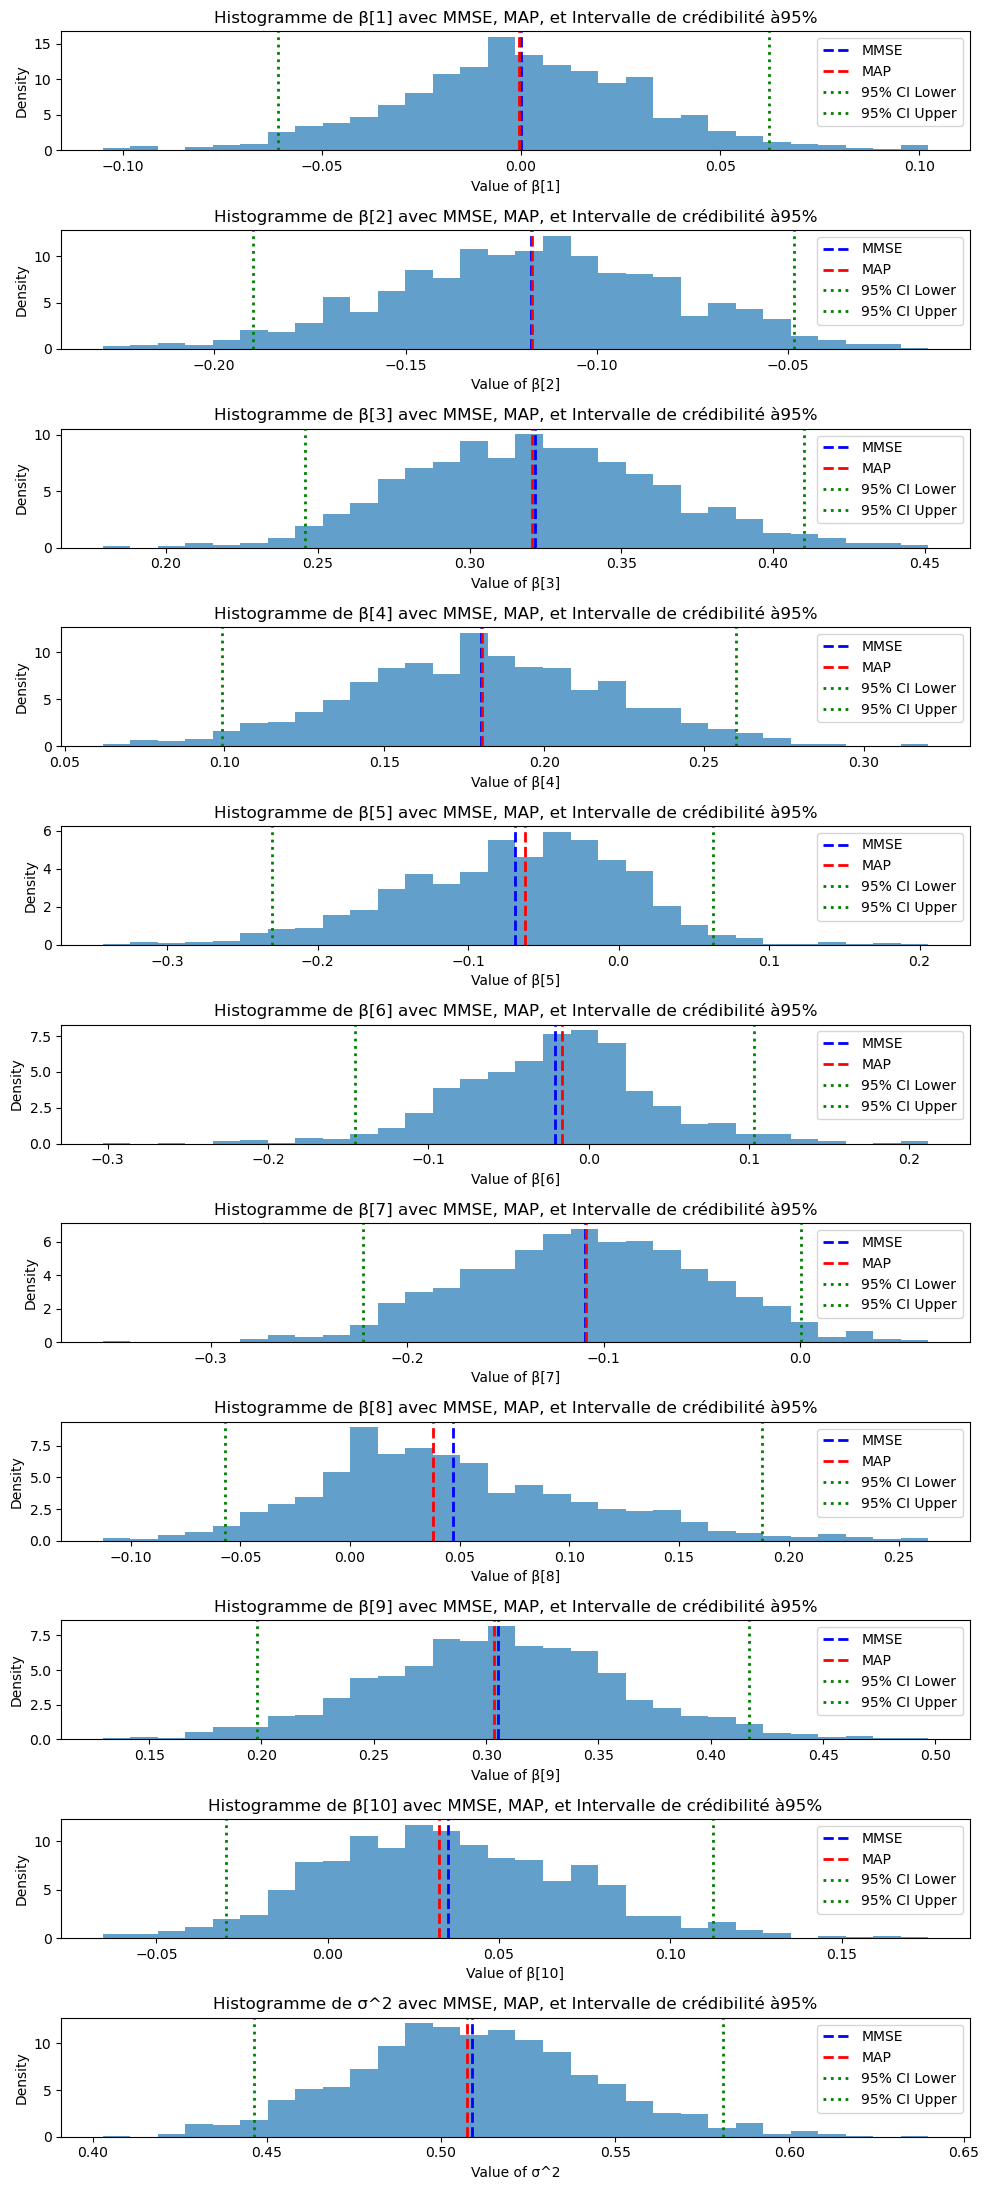

In [14]:
# Calcul de MMSE et MAP
mmse_estimates = np.mean(samples, axis=0)
map_estimates = np.array([np.median(samples[:, i]) for i in range(num_params)])

# Intervalle de crédibilité à 95%
credibility_intervals = np.array([np.percentile(samples[:, i], [2.5, 97.5]) for i in range(num_params)])

# Création d'histogrammes avec les estimations MMSE et MAP
fig, axes = plt.subplots(num_params, 1, figsize=(10, 2 * num_params))

for i in range(num_params):
    ax = axes[i]
    ax.hist(samples[:, i], bins=30, density=True, alpha=0.7)
    ax.axvline(mmse_estimates[i], color='blue', linestyle='dashed', linewidth=2, label='MMSE')
    ax.axvline(map_estimates[i], color='red', linestyle='dashed', linewidth=2, label='MAP')
    ax.axvline(credibility_intervals[i][0], color='green', linestyle='dotted', linewidth=2, label='95% CI Lower')
    ax.axvline(credibility_intervals[i][1], color='green', linestyle='dotted', linewidth=2, label='95% CI Upper')
    ax.set_title(f"Histogramme de {param_names[i]} avec MMSE, MAP, et Intervalle de crédibilité à95%")
    ax.set_xlabel(f"Value of {param_names[i]}")
    ax.set_ylabel("Density")
    ax.legend()

plt.tight_layout()
plt.show()

**Q3.** Générer 1000 échantillons de la loi prédictive a posteriori pour le nouveau point $x_{\text{new}}$ (défini dans le code) et tracer un histogramme ou un KDE. Commenter.

In [15]:
x_new = np.array([ 1.41145807,  1.06548848,  0.30006161,  0.45984057, -0.52475728,
       -1.70643289,  1.02259953,  1.49710409, -1.25030999,  0.84817082])



#en utilisant les échantillons de beta et sigma2 créer avant, on peut calculer la distribution de y sachant x_new




y_list=[]
for k in range(len(samples)):
    y_list.append(ss.norm.rvs(loc=x_new.T.dot(samples[k,:-1]), scale=np.sqrt(samples[k,-1])))
y_list=np.array(y_list)
µ_y=np.round(np.mean(y_list),3)
σ_y=np.round(np.std(y_list),3)
fig = go.Figure()
fig.add_trace(go.Histogram(x=y_list,histnorm='probability density' ,name='y'))
#add the density
x=np.linspace(-3,3,100)
fig.add_trace(go.Scatter(x=x,y=ss.norm.pdf(x,loc=µ_y, scale= σ_y),name='normal distribution'))
# add mean and variance of y with an arrow pointing towards a line at the mean of y
fig.add_trace(go.Scatter(x=[np.mean(y_list),np.mean(y_list)],y=[0,0.6],mode='lines',name='mean of y'))
fig.add_annotation(x=np.mean(y_list),y=0.6,text='µ_y= '+str(µ_y)+',  σ_y= '+ str(σ_y),arrowhead=2,arrowsize=1,arrowwidth=3,arrowcolor='black')
fig.show()

In [16]:
# par curiosité ont trace la distribution de y sachant x_new avec les paramètres MMSE (=la moyenne des paramètres précédents)



#generer des points avec la loi posterior
y_list=[]
for i in range(1000):
    y_list.append(ss.norm.rvs(loc=x_new.T.dot(mmse_estimates[:-1]), scale=np.sqrt(mmse_estimates[-1])))
y_list=np.array(y_list)
µ_y=np.round(x_new.T.dot(mmse_estimates[:-1]),3)
σ_y=np.round(np.sqrt(mmse_estimates[-1]),3)
#plot the histogram of the X_list[j] , add the density of the normal distribution with mean=mmse_estimates and variance=mmse_estimates[-1]
fig = go.Figure()
fig.add_trace(go.Histogram(x=y_list,histnorm='probability density' ,name='y'))
#add the density 
x=np.linspace(-3,3,100)
fig.add_trace(go.Scatter(x=x,y=ss.norm.pdf(x,loc=x_new.T.dot(mmse_estimates[:-1]), scale=np.sqrt(mmse_estimates[-1])),name='normal distribution'))
# add mean and variance of y with an arrow pointing towards a line at the mean of y
fig.add_trace(go.Scatter(x=[np.mean(y_list),np.mean(y_list)],y=[0,0.6],mode='lines',name='mean of y'))
fig.add_annotation(x=np.mean(y_list),y=0.6,text='µ_y= '+str(µ_y)+',  σ_y= '+ str( σ_y),arrowhead=2,arrowsize=1,arrowwidth=3,arrowcolor='black')
fig.show()

### Observations 
>
>

Nous avons bien généré 1000 échantillons en $x_{\text{new}}$ en utilisant les 1000 paramètres échantillonés plus tot, puis 1000 fois avec les paramètres moyens. La densité tracée sur les deux graphiques est respectivement celle calculée avec la moyenne et la variances des y échantillonés et celle calculée avec les paramètres moyens.
On peut voir que les histogrammes sont simialires et suivent bien une normale malgré la variabilité que nous avons introduite dans les paramètres. 
Si l'on augmentait le nombre d'échantillons, on pourrait s'attendre à ce que les deux densités tendent vers les mêmes valeurs.

**Q4.** Étudier l'influence du paramètre lambda sur l'inférence des paramètres.

Sans l'implémenter, à l'aide de vos connaissances, pouvez-vous proposer une méthode permettant de choisir lambda ?

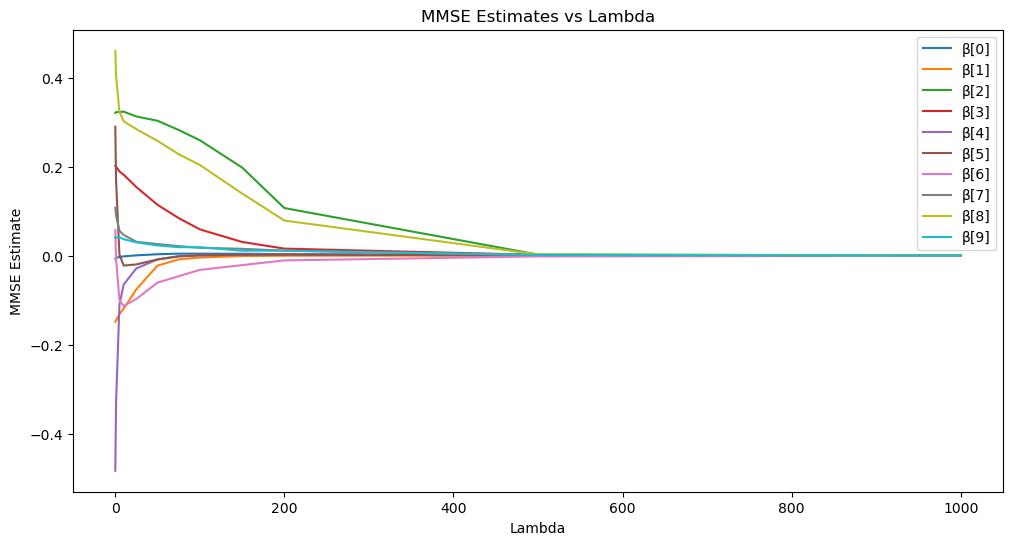

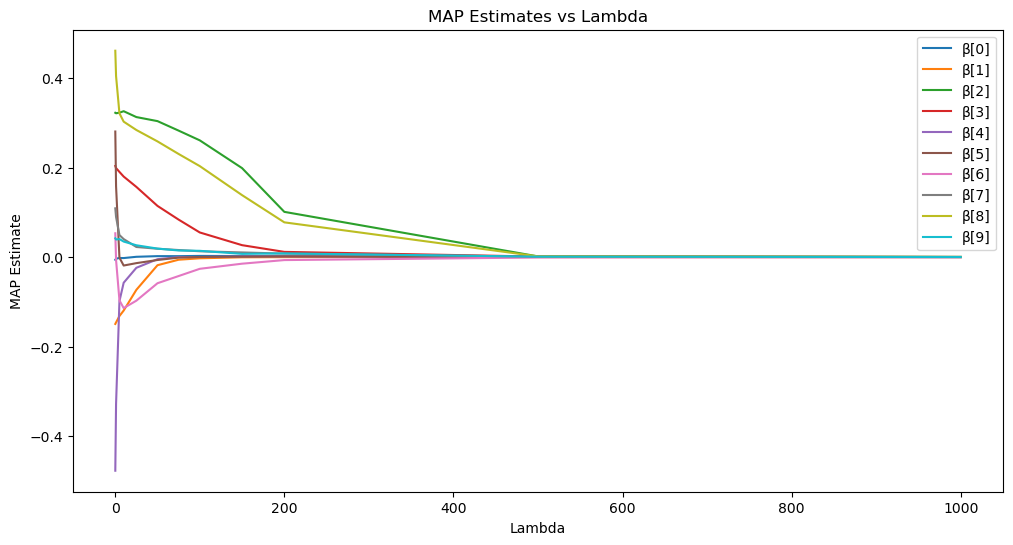

In [17]:
lambda_values = [0.1,1,5,10,25,50,75,100,150,200,500,1000]  

# Initialiser des listes pour stocker les résultats
mmse_estimates_list = []
map_estimates_list = []
for lambda_ in lambda_values:
    # Ajuster le modèle avec la valeur courante de λ
    current_samples = bayesian_lasso_gibbs(X, y, Ng, Nb, a0, b0, lambda_)
    
    # Calculer les estimations MMSE et MAP 
    mmse_estimates = np.mean(current_samples[:, :-1], axis=0)  # Exclure σ^2 pour les estimations β
    map_estimates = np.array([np.median(current_samples[:, i]) for i in range(P)])
    
    # Stocker les résultats
    mmse_estimates_list.append(mmse_estimates)
    map_estimates_list.append(map_estimates)

# Graphique des estimations MMSE
plt.figure(figsize=(12, 6))
for i in range(len(mmse_estimates_list[0])):  # Parcourir chaque coefficient
    plt.plot(lambda_values, [estimate[i] for estimate in mmse_estimates_list], label=f'β[{i}]')

plt.xlabel('Lambda')
plt.ylabel('MMSE Estimate')
plt.title('MMSE Estimates vs Lambda')
plt.legend()
plt.show()

# Graphique des estimations MAP
plt.figure(figsize=(12, 6))
for i in range(len(map_estimates_list[0])):  # Parcourir chaque coefficient
    plt.plot(lambda_values, [estimate[i] for estimate in map_estimates_list], label=f'β[{i}]')

plt.xlabel('Lambda')
plt.ylabel('MAP Estimate')
plt.title('MAP Estimates vs Lambda')
plt.legend()
plt.show()

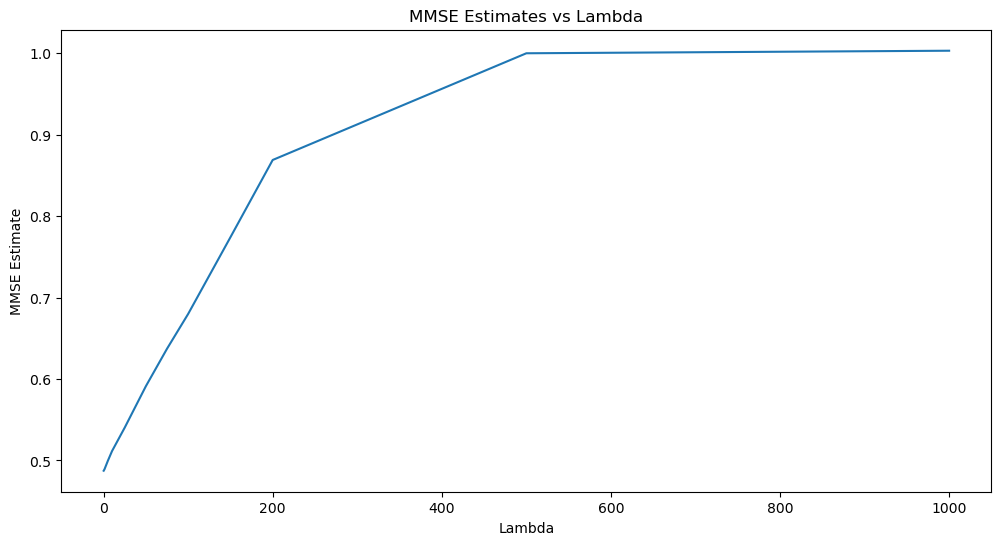

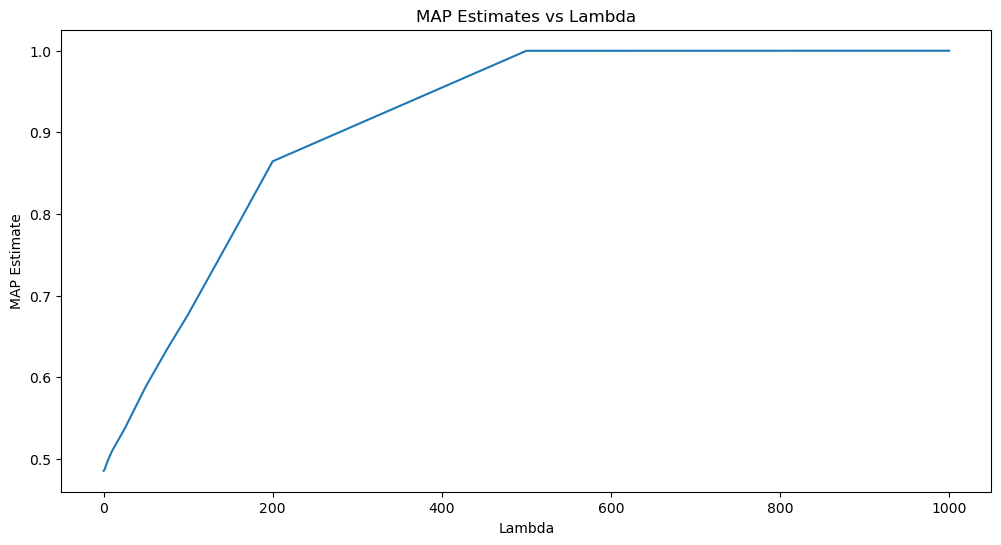

In [18]:
#do the same with sigma^2

# Initialiser des listes pour stocker les résultats
mmse_estimates_list = []
map_estimates_list = []
for lambda_ in lambda_values:
    # Ajuster le modèle avec la valeur courante de λ
    current_samples = bayesian_lasso_gibbs(X, y, Ng, Nb, a0, b0, lambda_)
    
    # Calculer les estimations MMSE et MAP 
    mmse_estimates = np.mean(current_samples[:, -1])  
    map_estimates = np.median(current_samples[:, -1])
    
    # Stocker les résultats
    mmse_estimates_list.append(mmse_estimates)
    map_estimates_list.append(map_estimates)

# Graphique des estimations MMSE
plt.figure(figsize=(12, 6))
plt.plot(lambda_values, mmse_estimates_list)
plt.xlabel('Lambda')
plt.ylabel('MMSE Estimate')
plt.title('MMSE Estimates vs Lambda')
plt.show()

# Graphique des estimations MAP
plt.figure(figsize=(12, 6))
plt.plot(lambda_values, map_estimates_list)
plt.xlabel('Lambda')
plt.ylabel('MAP Estimate')
plt.title('MAP Estimates vs Lambda')
plt.show()



### Observations 

> On peut en déduire que le paramètre lambda agit bien comme paramètre de régularisation dans ce contexte Bayesien. On tends vers une distribution normale centrée réduite lorsque lambda tends vers l'infini.
En pratique, le choix de λ est souvent déterminé par la validation croisée ou d'autres méthodes d'optimisation pour trouver une valeur qui offre un bon compromis entre ajustement du modèle aux données d'apprentissage et généralisation aux nouvelles données.
On pourrait aussi l'utiliser le critère BIC que nous avions utilisé dans un autre TP.

**Questions bonus**. Le TP est déjà long. Votre objectif premier est d'effectuer les questions précédentes correctement.

S'il vous reste du temps et de la motivation, voici deux questions "papier-crayon" :
* Montrer que l'estimation MAP dans un modèle avec un *prior* Laplace pour les coefficients de régression mène bien au même problème que le LASSO
* Dériver la loi conditionnelle pour $\boldsymbol{\beta}$ ou $\sigma^2$. Attention ! Le calcul de la loi conditionnelle de $\tau_i$ est quant à lui très compliqué. Ne le tentez pas sans l'aide d'un(e) professionnel(le).